In [1]:
import warnings
warnings.filterwarnings('ignore')
from keras.layers import Input, Dense, Flatten, Dropout
from keras.models import Model
from keras.regularizers import l2
import numpy as np
import pandas as pd
import random
from collections import deque
import matplotlib.pylab as plt
from utils import *
from datetime import datetime
from aux_plots import ploty_basic,plot_results

Using TensorFlow backend.


# Deep Q learnig agent
 * training a deep q learning agente (value Function Approximator) ond the same environment as the others with discrete set of actions

In [2]:
class Factor_environment():
    
    def __init__(self,capital = 1e6,cotas = None):
        
        self.data = cotas.set_index("date")
                
    # considering each factor strat as an asset starting at price = 1  at  d0
    def load_data(self):
        
        return self.cotas
        
    def preprocess_state(self, state):
        
        return state
    
    def get_state(self, t, lookback, is_cov_matrix = True, is_raw_time_series = False):
        
        assert lookback <= t
        
        decision_making_state = self.data.iloc[t-lookback:t]
        decision_making_state = decision_making_state.pct_change().dropna()
    
        if is_cov_matrix:
            x = decision_making_state.cov()
            return x
        
        else:
            
            if is_raw_time_series:
                decision_making_state = self.data.iloc[t-lookback:t]
            
            return self.preprocess_state(decision_making_state)
            
    
    def get_reward(self, action, action_t, reward_t):
        
        def local_portfolio(returns, weights):
            weights = np.array(weights)
            rets = returns.mean() # * 252
            covs = returns.cov() # * 252
            P_ret = np.sum(rets * weights)
            P_vol = np.sqrt(np.dot(weights.T, np.dot(covs, weights)))
            P_sharpe = P_ret / P_vol
            return np.array([P_ret, P_vol, P_sharpe])
        
        weights = action
        returns = self.data[action_t:reward_t].pct_change().dropna()
        
        rew = local_portfolio(returns, weights)[-1]
        rew = np.array([rew] * len(self.data.columns))
        
        return np.dot(returns, weights), rew
    
    
class Agent:
    
    def __init__(self, portfolio_size,is_eval = False, allow_short = True):
        
        self.portfolio_size = portfolio_size
        self.allow_short = allow_short
        
        self.input_shape = (portfolio_size, portfolio_size, )
        
        # hold, buy, sell
        self.action_size = 3 
        
        self.memory4replay = []
        self.is_eval = is_eval

        # value function paramers
        self.alpha = 0.5
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.99
        
        self.model = self._model()

    def _model(self):
        
        inputs = Input(shape=self.input_shape)
        x = Flatten()(inputs)
        x = Dense(100, activation='elu')(x)
        x = Dropout(0.5)(x)
        x = Dense(50, activation='elu')(x)
        x = Dropout(0.5)(x)
        
        predictions = []
        for i in range(self.portfolio_size):
            asset_dense = Dense(self.action_size, activation='linear')(x)   
            predictions.append(asset_dense)
        
        model = Model(inputs=inputs, outputs=predictions)
        model.compile(optimizer='adam', loss='mse')
        return model

    def nn_pred_to_weights(self, pred, allow_short = False):

        weights = np.zeros(len(pred))
        raw_weights = np.argmax(pred, axis=-1)

        saved_min = None
        
        for e, r in enumerate(raw_weights):
            if r == 0: # sit
                weights[e] = 0
            elif r == 1: # buy
                weights[e] = np.abs(pred[e][0][r])
            else:
                weights[e] = -np.abs(pred[e][0][r])

        if not allow_short:
            weights += np.abs(np.min(weights))
            saved_min = np.abs(np.min(weights))
            saved_sum = np.sum(weights)
        else:
            saved_sum = np.sum(np.abs(weights))
            
        weights /= saved_sum
        return weights, saved_min, saved_sum
    
    def act(self, state):
        
        if not self.is_eval and random.random() <= self.epsilon:
            w = np.random.normal(0, 1, size = (self.portfolio_size, ))  
              
            saved_min = None
            
            if not self.allow_short:
                w += np.abs(np.min(w))
                saved_min = np.abs(np.min(w))
                
            saved_sum = np.sum(w)
            w /= saved_sum
            return w , saved_min, saved_sum

        pred = self.model.predict(np.expand_dims(state.values, 0))
        return self.nn_pred_to_weights(pred, self.allow_short)
    
    
    def expReplay(self, batch_size):

        def weights_to_nn_preds_with_reward(action_weights, 
                                            reward, 
                                            Q_star = np.zeros((self.portfolio_size, self.action_size))): 
            
            Q = np.zeros((self.portfolio_size, self.action_size))           
            
            for i in range(self.portfolio_size):
                if action_weights[i] == 0:
                    Q[i][0] = reward[i] + self.gamma * np.max(Q_star[i][0])
                
                elif action_weights[i] > 0:
                    
                    Q[i][1] = reward[i] + self.gamma * np.max(Q_star[i][1])
                
                else:
                    Q[i][2] = reward[i] + self.gamma * np.max(Q_star[i][2])            
            return Q  
        
        def restore_Q_from_weights_and_stats(action):            
            action_weights, action_min, action_sum = action[0], action[1], action[2]
            action_weights = action_weights * action_sum          
            if action_min != None:
                action_weights = action_weights - action_min   
            return action_weights
        
        for (s, s_, action, reward, done) in self.memory4replay:
            
            action_weights = restore_Q_from_weights_and_stats(action) 
            Q_learned_value = weights_to_nn_preds_with_reward(action_weights, reward)
            s, s_ = s.values, s_.values    

            if not done:
                # reward + gamma * Q^*(s_, a_)
                Q_star = self.model.predict(np.expand_dims(s_, 0))
                Q_learned_value = weights_to_nn_preds_with_reward(action_weights, reward, np.squeeze(Q_star))  

            Q_learned_value = [xi.reshape(1, -1) for xi in Q_learned_value]
            Q_current_value = self.model.predict(np.expand_dims(s, 0))
            Q = [np.add(a * (1-self.alpha), q * self.alpha) for a, q in zip(Q_current_value, Q_learned_value)]
            
            # update current Q function with new optimal value
            self.model.fit(np.expand_dims(s, 0), Q, epochs=1, verbose=0)            
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay 

# Training

In [3]:
N_ASSETS = 3
agent = Agent(N_ASSETS)

quotas = pd.read_csv("cotas_factors.csv")
quotas["date"] = quotas["date"].apply(lambda x: datetime.strptime(x,"%d/%m/%Y").date())
env = Factor_environment(cotas = quotas)
dados = env.data
datas = dados.index.tolist()
datas = [str(el) for el in datas]
window_size = 180
episode_count = 50
batch_size = 32
rebalance_period = 180

In [4]:
for e in range(episode_count):
    
    agent.is_eval = False
    data_length = len(env.data)
    
    returns_history = []
    returns_history_equal = []
    
    rewards_history = []
    equal_rewards = []
    
    actions_to_show = []
    
    print("Episode " + str(e) + "/" + str(episode_count), 'epsilon', agent.epsilon)

    s = env.get_state(np.random.randint(window_size+1, data_length-window_size-1), window_size)
    total_profit = 0 

    for t in range(window_size, data_length, rebalance_period):

        date1 = t-rebalance_period
        
        s_ = env.get_state(t, window_size)
        action = agent.act(s_)
        
        actions_to_show.append(action[0])

        weighted_returns, reward = env.get_reward(action[0], date1, t)
        weighted_returns_equal, reward_equal = env.get_reward(
            np.ones(agent.portfolio_size) / agent.portfolio_size, date1, t)

        rewards_history.append(reward)
        equal_rewards.append(reward_equal)
        returns_history.extend(weighted_returns)
        returns_history_equal.extend(weighted_returns_equal)

        done = True if t == data_length else False
        agent.memory4replay.append((s, s_, action, reward, done))
        
        if len(agent.memory4replay) >= batch_size:
            agent.expReplay(batch_size)
            agent.memory4replay = []
            
        s = s_

    rl_result = np.array(returns_history).cumsum()
    equal_result = np.array(returns_history_equal).cumsum()
        

Episode 0/50 epsilon 1.0
Episode 1/50 epsilon 1.0

Episode 2/50 epsilon 0.99
Episode 3/50 epsilon 0.99
Episode 4/50 epsilon 0.9801
Episode 5/50 epsilon 0.9801
Episode 6/50 epsilon 0.9702989999999999
Episode 7/50 epsilon 0.9702989999999999
Episode 8/50 epsilon 0.96059601
Episode 9/50 epsilon 0.96059601
Episode 10/50 epsilon 0.9509900498999999
Episode 11/50 epsilon 0.9509900498999999
Episode 12/50 epsilon 0.9414801494009999
Episode 13/50 epsilon 0.9414801494009999
Episode 14/50 epsilon 0.9320653479069899
Episode 15/50 epsilon 0.9320653479069899
Episode 16/50 epsilon 0.92274469442792
Episode 17/50 epsilon 0.9135172474836407
Episode 18/50 epsilon 0.9135172474836407
Episode 19/50 epsilon 0.9043820750088043
Episode 20/50 epsilon 0.9043820750088043
Episode 21/50 epsilon 0.8953382542587163
Episode 22/50 epsilon 0.8953382542587163
Episode 23/50 epsilon 0.8863848717161291
Episode 24/50 epsilon 0.8863848717161291
Episode 25/50 epsilon 0.8775210229989678
Episode 26/50 epsilon 0.8775210229989678
Ep

# avaliando

In [5]:
agent.is_eval = True

actions_equal, actions_rl = [], []
result_equal, result_rl = [], []
list_datas = []
for t in range(window_size, len(env.data), rebalance_period):
    list_datas.append(datas[t])
    date1 = t-rebalance_period
    s_ = env.get_state(t, window_size)
    action = agent.act(s_)

    weighted_returns, reward = env.get_reward(action[0], date1, t)
    weighted_returns_equal, reward_equal = env.get_reward(
        np.ones(agent.portfolio_size) / agent.portfolio_size, date1, t)

    result_equal.append(weighted_returns_equal.tolist())
    actions_equal.append(np.ones(agent.portfolio_size) / agent.portfolio_size)
    
    result_rl.append(weighted_returns.tolist())
    actions_rl.append(action[0])
    
datas_temp = pd.DataFrame({"date":list_datas})
result_equal_vis = [item for sublist in result_equal for item in sublist]
result_rl_vis = [item for sublist in result_rl for item in sublist]

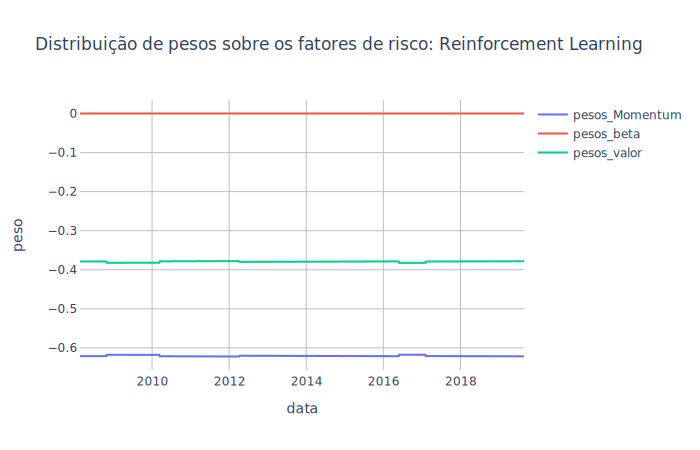

In [6]:
def createSeries(datas_temp,lista_actions):
    lista_vol = []
    lista_mom = []
    lista_beta = []
    lista_valor = []
    for el in range(len(lista_actions)):
        #lista_vol.append(lista_actions[el][0])
        lista_mom.append(lista_actions[el][0])
        lista_beta.append(lista_actions[el][1])
        lista_valor.append(lista_actions[el][2])
        
    df_weights = pd.DataFrame({"date":datas_temp["date"].tolist(),
                               "pesos_Momentum":lista_mom,"pesos_beta":lista_beta,"pesos_valor":lista_valor})    
    return df_weights


ww = createSeries(datas_temp,actions_rl)
datas_full = pd.DataFrame({"date":datas})
datas_full["val"] = 1
complete = pd.merge(datas_full,ww,left_on=["date"],right_on="date",how="left")
dt_min = complete[~pd.isnull(complete["pesos_beta"])]["date"].min()
complete = complete[complete["date"]>=dt_min]
complete.fillna(method='ffill',inplace=True)


ploty_basic(complete,"date",["pesos_Momentum","pesos_beta","pesos_valor"],title="Distribuição de pesos sobre os fatores de risco: Reinforcement Learning",y_title="peso",x_title="data")

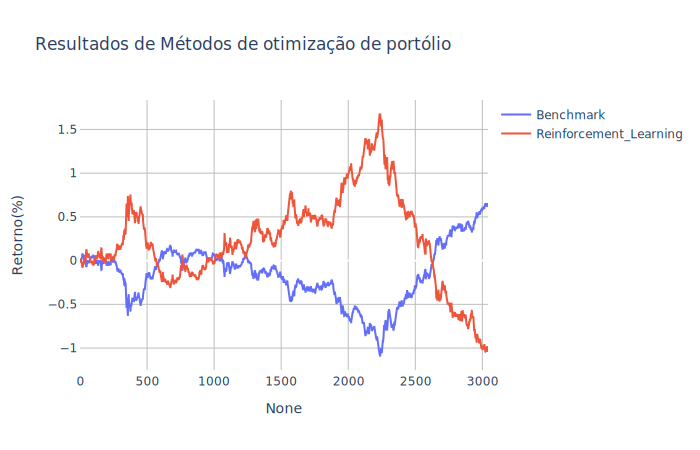

In [7]:
df_eqt = pd.DataFrame({"Benchmark":np.array(result_equal_vis).cumsum(),
              "Reinforcement_Learning":np.array(result_rl_vis).cumsum()})


df_eqt["x"] = df_eqt.index
df_eqt

ploty_basic(df_eqt,"x",["Benchmark","Reinforcement_Learning"],title="Resultados de Métodos de otimização de portólio",y_title="Retorno(%)")